# Setting & Scraping the Data

## Collecting movies since 1990

In [ ]:
def get_movies_since(year):
    import pandas as pd
    year_data = pd.read_csv('year.csv', on_bad_lines='skip', sep="\t")
    movie_data = year_data[year_data["titleType"].isin(["movie", "tvMovie"])]
    movie_data_with_year = movie_data[movie_data["startYear"] >= "1990"]
    movie_data_with_valid_year = movie_data_with_year[movie_data_with_year["startYear"] != "\\N"]
    movie_data_with_valid_year = movie_data_with_valid_year[["tconst", "startYear", "originalTitle"]]

    imdb_data = pd.read_csv("ratings.csv", sep="\t")

    year_vote_data = pd.merge(imdb_data, movie_data_with_valid_year, on="tconst", how="right")
    year_vote_data = year_vote_data[["tconst","startYear","averageRating","numVotes", "originalTitle"]]
    year_vote_data.columns = ["title id","Year","Rating","Votes", "Title"]
    year_vote_data["rating link"] = "https://www.imdb.com/title/"+year_vote_data["title id"]+"/ratings/?ref_=tt_ov_rt"
    year_vote_data = year_vote_data.sort_values(by="title id").reset_index(drop=True)
    year_vote_data.to_csv("movies_since_"+"1990"+".csv", index=False)

    return year_vote_data
dataset = get_movies_since("1990")

## extracting vote data

In [26]:
def get_votes(link, vote_threshold=10000):
    import requests, re
    request_text = requests.get(link).text
    if "No Ratings Available" in request_text or "Well, what if there is no webpage?" in request_text or int(((request_text[request_text.index("IMDb users have given a ")-15:request_text.index("IMDb users have given a ")-1].strip()).replace(",",""))) < vote_threshold:
        return [0,0,0,0,0,0,0,0,0,0], 0.0

    star_votes = re.findall("<div class=\"leftAligned\">(.*?)</div>", request_text)
    rating = re.findall("span class=\"ipl-rating-star__rating\">(.*?)</span>", request_text)
    stars = [int(vote.replace(",","")) for vote in star_votes[1:11]]
    
    return stars, float(rating[0])

In [4]:
# 1 second for a link
stars, rating = get_votes("https://www.imdb.com/title/tt0068646/ratings/?ref_=tt_ov_rt", vote_threshold=10000)

In [38]:
def fill_dataset(dataset, start=0, end=0, zip=1):
    for i in range(start, end):
        try:
            stars, rating = get_votes(dataset.iloc[i]["rating link"])
            dataset.loc[i,["1","2","3","4","5","6","7","8","9","10"]] = stars
            dataset.loc[i,["Rating","Votes"]] = rating, sum(stars)
        except:
            pass
        if i % 100 == 0:
            print(i,". movie done between ",start,"-",end, sep="")

    if zip:
        print(end,". movie done between ",start,"-",end, sep="")
        dataset[:end].to_csv("movie_data_at_"+str(start)+"_"+str(end)+".csv", index=False)
    return dataset

In [ ]:
import pandas as pd
dataset = pd.read_csv("movie_data_at_5000_6000.csv")
dataset = fill_dataset(dataset, start=6000, end=7000, zip=1)

## Merging movie and box office datasets

In [1]:
def merge_movies_with_boxoffices(movie_csv_path, how_to_merge):
    import pandas as pd
    dataset = pd.read_csv(movie_csv_path)
    dataset = dataset[~dataset["1"].isnull()]
    dataset = dataset[dataset["Votes"]>0]
    dataset["Title-Year"] = dataset["Year"].astype(str) + " " + dataset["Title"]

    movie_box_dataset = pd.read_csv("year_movie_worldwide_box.csv")
    movie_box_dataset.columns =  ["Year", "Title", "WorldwideBox Office"]
    movie_box_dataset["Title-Year"] = movie_box_dataset["Year"].astype(int).astype(str) + " " + movie_box_dataset["Title"]

    including_movies = movie_box_dataset[movie_box_dataset["Title-Year"].isin(list(dataset["Title-Year"]))]
    merge = pd.merge(dataset, including_movies[["Title-Year","WorldwideBox Office"]], on="Title-Year", how=how_to_merge)
    return merge

In [ ]:
merge = merge_movies_with_boxoffices("informative_movie_data.csv", "outer")
merge.head(3)

## Getting revenues

In [ ]:
def get_revenue(link):
    import requests
    text = requests.get(link).text
    if "<span class=\"ipc-metadata-list-item__label\">Gross worldwide</span>" in text:
        revenue_part = text[text.index("<span class=\"ipc-metadata-list-item__label\">Gross worldwide</span>"):]
        revenue = int(revenue_part[revenue_part.index("$")+1:].split("</span>")[0].replace(",",""))
        return revenue
    raise Exception("cant find worldwide gross")

In [ ]:
def fill_revenues(dataset, start=0, end=0, zip=1):
    from datetime import datetime

    for i in range(start, end):
        try:
            revenue = get_revenue(dataset.iloc[i]["imdb_url"])
            dataset.loc[i,"WorldwideBox Office"] = revenue
        except:
            pass
        if i % 100 == 0:
            print(datetime.now().strftime("%H:%M:%S"), " ..... ", i,". movie done between ",start,"-",end, sep="")
            if i%1000 == 0 and zip:
                dataset[:end].to_csv("movie_revenue_data_at_"+str(start)+"_"+str(end)+".csv", index=False)

    dataset.to_csv("movie_revenue_data_all.csv", index=False)
    return dataset

In [ ]:
def get_revenue_from_wikipedia(title_year):
    import requests
    year, title = title_year[:title_year.index(" ")], title_year[title_year.index(" ")+1:]

    try:
        text = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")).text
        a = text[text.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    try:
        text_film = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")+"_(film)").text
        a = text_film[text_film.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    try:
        text_film_year = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")+"_("+year+"_film)").text
        a = text_film_year[text_film_year.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    raise Exception("cant find worldwide gross")

In [ ]:
def fill_revenues_from_wikipedia(dataset, indices, start=0, end=0, zip=1):
    from datetime import datetime

    for i in indices:
        try:
            revenue = get_revenue_from_wikipedia(dataset.iloc[i]["Title-Year"])
            dataset.loc[i,"WorldwideBox Office"] = revenue
        except:
            pass
        if i % 100 == 0:
            print(datetime.now().strftime("%H:%M:%S"), " ..... ", i,". movie done between ",start,"-",end, sep="")
            if i%1000 == 0 and zip:
                dataset[:end].to_csv("movie_revenue_data_at_"+str(start)+"_"+str(end)+".csv", index=False)

    dataset.to_csv("movie_revenue_data_all.csv", index=False)
    return dataset

# Exploring data

## Checking data

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv("movie_revenue_data.csv")
data = pd.DataFrame(data)

In [2]:
data

,Title,Year,Rating,Votes,1,2,3,4,5,6,7,8,9,10,WorldwideBox Office
0,Kate & Leopold,2001,6.4,84837.0,5747.0,4409.0,11615.0,23031.0,21676.0,10417.0,4195.0,1840.0,934.0,973.0,76019048.0
1,3 Men and a Little Lady,1990,5.4,24975.0,1482.0,691.0,1698.0,3363.0,5619.0,5822.0,3195.0,1617.0,793.0,695.0,71609321.0
2,The Adventures of Ford Fairlane,1990,6.4,18338.0,3060.0,1462.0,2690.0,3255.0,2726.0,1723.0,1166.0,811.0,635.0,810.0,21413502.0
3,Air America,1990,5.8,28924.0,1195.0,663.0,2123.0,5338.0,8555.0,6295.0,2629.0,1110.0,489.0,527.0,33461269.0
4,Alice,1990,6.6,14431.0,722.0,781.0,2274.0,4450.0,3486.0,1447.0,547.0,242.0,154.0,328.0,7331647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7522,Major,2022,8.2,26633.0,15787.0,3848.0,2983.0,1725.0,753.0,334.0,175.0,113.0,130.0,785.0,4961424.0
7523,Malang - Unleash the Madness,2020,6.5,10831.0,1801.0,862.0,1773.0,2425.0,1599.0,810.0,379.0,224.0,186.0,772.0,8399765.0
7524,I Care a Lot,2020,6.3,132399.0,5922.0,6346.0,19670.0,34795.0,25626.0,11858.0,6389.0,4521.0,3958.0,13314.0,1351662.0
7525,Kaithi,2019,8.5,31255.0,13638.0,7743.0,5705.0,2371.0,732.0,286.0,128.0,79.0,88.0,485.0,522938.0


**Feature eng denemesi**

In [102]:
sec_data = pd.read_csv("movie_revenue_data.csv")

In [103]:
fe = pd.DataFrame(sec_data)

fe['1-3'] = (fe['1'] + fe['2'] + fe['3'])/fe['Votes']
fe['4-6'] = (fe['4'] + fe['5'] + fe['6'])/fe['Votes']
fe['7-8'] = (fe['7'] + fe['8'])/fe['Votes']
fe['9-10'] = (fe['9'] + fe['10'])/fe['Votes']

fe.drop(['1','2','3','4','5','6','7','8','9','10'], inplace=True, axis=1)


In [104]:
fe

,Title,Year,Rating,Votes,WorldwideBox Office,1-3,4-6,7-8,9-10
0,Kate & Leopold,2001,6.4,84837.0,76019048.0,0.256622,0.649764,0.071136,0.022478
1,3 Men and a Little Lady,1990,5.4,24975.0,71609321.0,0.154995,0.592753,0.192673,0.059580
2,The Adventures of Ford Fairlane,1990,6.4,18338.0,21413502.0,0.393282,0.420111,0.107809,0.078798
3,Air America,1990,5.8,28924.0,33461269.0,0.137637,0.697967,0.129270,0.035127
4,Alice,1990,6.6,14431.0,7331647.0,0.261728,0.650197,0.054674,0.033400
...,...,...,...,...,...,...,...,...,...
7522,Major,2022,8.2,26633.0,4961424.0,0.849247,0.105583,0.010814,0.034356
7523,Malang - Unleash the Madness,2020,6.5,10831.0,8399765.0,0.409565,0.446312,0.055674,0.088450
7524,I Care a Lot,2020,6.3,132399.0,1351662.0,0.241225,0.545918,0.082402,0.130454
7525,Kaithi,2019,8.5,31255.0,522938.0,0.866613,0.108431,0.006623,0.018333


In [105]:
fe["Year"] = (fe["Year"]-1990)/30
fe["Rating"] = fe["Rating"]/10

In [106]:
import math 
SEED = int(math.sqrt(201401004 + 191401009))

In [107]:
from sklearn.model_selection import train_test_split
feX_train, feX_test, fey_train, fey_test = train_test_split(fe.drop(['Title','WorldwideBox Office'], axis=1), fe['WorldwideBox Office'], test_size=0.10, random_state=SEED)
feX_train, feX_validation, fey_train, fey_validation = train_test_split(feX_train, fey_train, test_size=0.1111111111111111, random_state=SEED)

In [108]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(feX_train, fey_train)
print("LinearRegression score on train:", LR.score(feX_train, fey_train))

LinearRegression score on train: 0.4301074057748182


In [109]:
feLR_validation_prediction = LR.predict(feX_validation)

from sklearn.metrics import mean_squared_error
print("Logistic Regression mean squared error on validation:", mean_squared_error(fey_validation, feLR_validation_prediction, squared=True))

from sklearn.metrics import mean_squared_error
print("Logistic Regression root mean squared error on validation:", mean_squared_error(fey_validation, feLR_validation_prediction ,squared=False))

from sklearn.metrics import mean_absolute_error
print("Logistic Regression mean absolute error on validation:", mean_absolute_error(fey_validation, feLR_validation_prediction))

from sklearn.metrics import r2_score
print("Logistic Regression r2 score on validation:", r2_score(fey_validation, feLR_validation_prediction))

#Adjusted R Squared:
print("Logistic Regression adjusted r2 score on validation:", 1-(1-r2_score(fey_validation, feLR_validation_prediction))*((len(fey_validation))-1)/((len(fey_validation))-len(feX_validation.columns)))

Logistic Regression mean squared error on validation: 1.8123031505076256e+16
Logistic Regression root mean squared error on validation: 134621809.17324004
Logistic Regression mean absolute error on validation: 59974437.679100685
Logistic Regression r2 score on validation: 0.3824609193698659
Logistic Regression adjusted r2 score on validation: 0.377494117112787


In [112]:
feLR_df = pd.DataFrame({"pred": feLR_validation_prediction, "actual": fey_validation})

In [113]:
feLR_df[abs(feLR_df['pred']-feLR_df['actual']) >= 20000000]

,pred,actual
6176,1.804374e+08,21947454.0
7517,2.895426e+07,1136431.0
3455,4.212239e+07,17068748.0
5703,4.880003e+07,2405143.0
2999,7.241116e+07,130154568.0
...,...,...
2945,1.080471e+08,15001776.0
4995,1.642975e+08,102731865.0
4672,6.615590e+07,123066041.0
5432,2.917259e+08,96983009.0


In [66]:
feLR_df

,pred,actual
6176,128614138.0,21947454.0
7517,3757606.0,1136431.0
3455,3056975.0,17068748.0
5703,2515035.0,2405143.0
2999,35100151.0,130154568.0
...,...,...
4362,792612.0,16920714.0
5432,121530612.0,96983009.0
4612,1628638.0,9075131.0
4402,1899831.0,487420.0


**Feature eng deneme bitiş**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7527 entries, 0 to 7526
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                7527 non-null   object 
 1   Year                 7527 non-null   int64  
 2   Rating               7527 non-null   float64
 3   Votes                7527 non-null   float64
 4   1                    7527 non-null   float64
 5   2                    7527 non-null   float64
 6   3                    7527 non-null   float64
 7   4                    7527 non-null   float64
 8   5                    7527 non-null   float64
 9   6                    7527 non-null   float64
 10  7                    7527 non-null   float64
 11  8                    7527 non-null   float64
 12  9                    7527 non-null   float64
 13  10                   7527 non-null   float64
 14  WorldwideBox Office  7527 non-null   float64
dtypes: float64(13), int64(1), object(1)
me

In [4]:
data.describe()

,Year,Rating,Votes,1,2,3,4,5,6,7,8,9,10,WorldwideBox Office
count,7527.000000,7527.000000,7.527000e+03,7.527000e+03,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7.527000e+03
mean,2008.128338,6.502949,9.852114e+04,1.221116e+04,12318.986449,21549.622957,22538.121828,14290.586954,7117.162880,3330.487977,1828.450910,1174.572207,2161.988707,7.866690e+07
std,8.286445,1.012327,1.736260e+05,4.340549e+04,40805.113220,46649.586549,34272.388366,18223.531560,8744.337904,4254.185511,2495.289187,1724.667779,4580.929819,1.690744e+08
min,1990.000000,1.000000,1.000200e+04,1.840000e+02,44.000000,23.000000,10.000000,7.000000,9.000000,6.000000,6.000000,13.000000,63.000000,5.800000e+01
25%,2002.000000,5.900000,1.805550e+04,1.434500e+03,1007.000000,2438.000000,3650.000000,2938.500000,1611.500000,702.000000,369.000000,240.000000,443.500000,3.312487e+06
50%,2009.000000,6.600000,3.798900e+04,3.186000e+03,2458.000000,5604.000000,8122.000000,6583.000000,3641.000000,1739.000000,926.000000,577.000000,936.000000,1.942817e+07
75%,2015.000000,7.200000,1.003410e+05,8.554500e+03,7450.500000,17266.000000,24688.500000,18410.500000,9244.000000,4240.000000,2289.500000,1408.500000,2177.000000,7.634441e+07
max,2022.000000,9.300000,2.649698e+06,1.459201e+06,739235.000000,484021.000000,282367.000000,165290.000000,96503.000000,55952.000000,41242.000000,34882.000000,140664.000000,2.923899e+09


In [5]:
data.isnull().sum().sum()

0

## Visualization

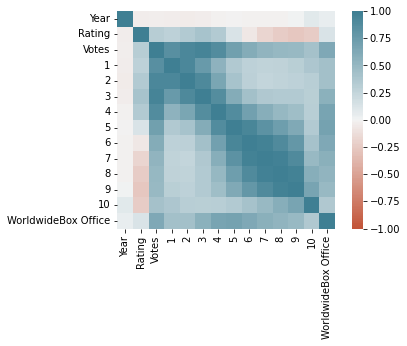

In [6]:
import seaborn as sns
ax = sns.heatmap(
    data[data.columns[1:]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

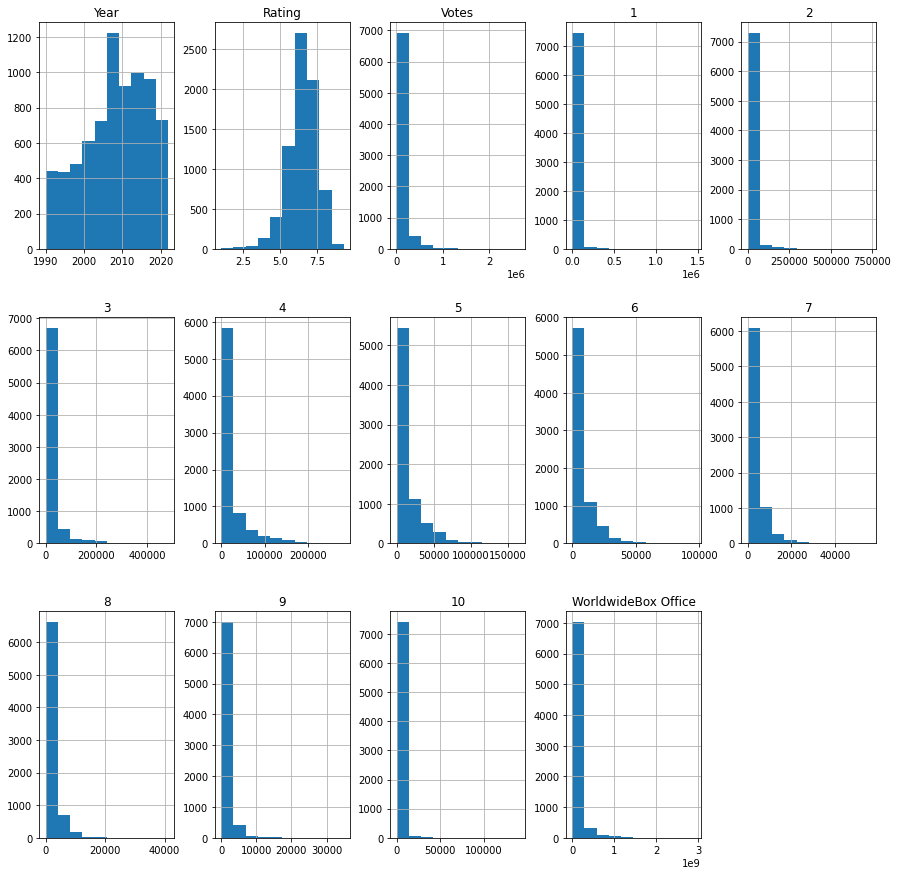

In [7]:
data[data.columns[1:]].hist(layout=(3,5), figsize=(15,15));

<AxesSubplot:>

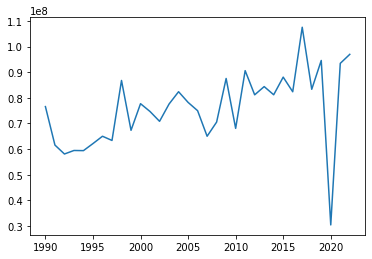

In [8]:
years = (data["Year"]).unique()
years.sort()
revenues = []
for year in (data["Year"]).unique():
    revenues.append(data[data["Year"] == year]["WorldwideBox Office"].mean())
sns.lineplot(x=years, y=revenues)

## splitting and normalization

In [3]:
data["Year"] = (data["Year"]-1990)/30
data["Rating"] = data["Rating"]/10
data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']] = np.log2(data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']])

AFTER NORMALIZATIONS


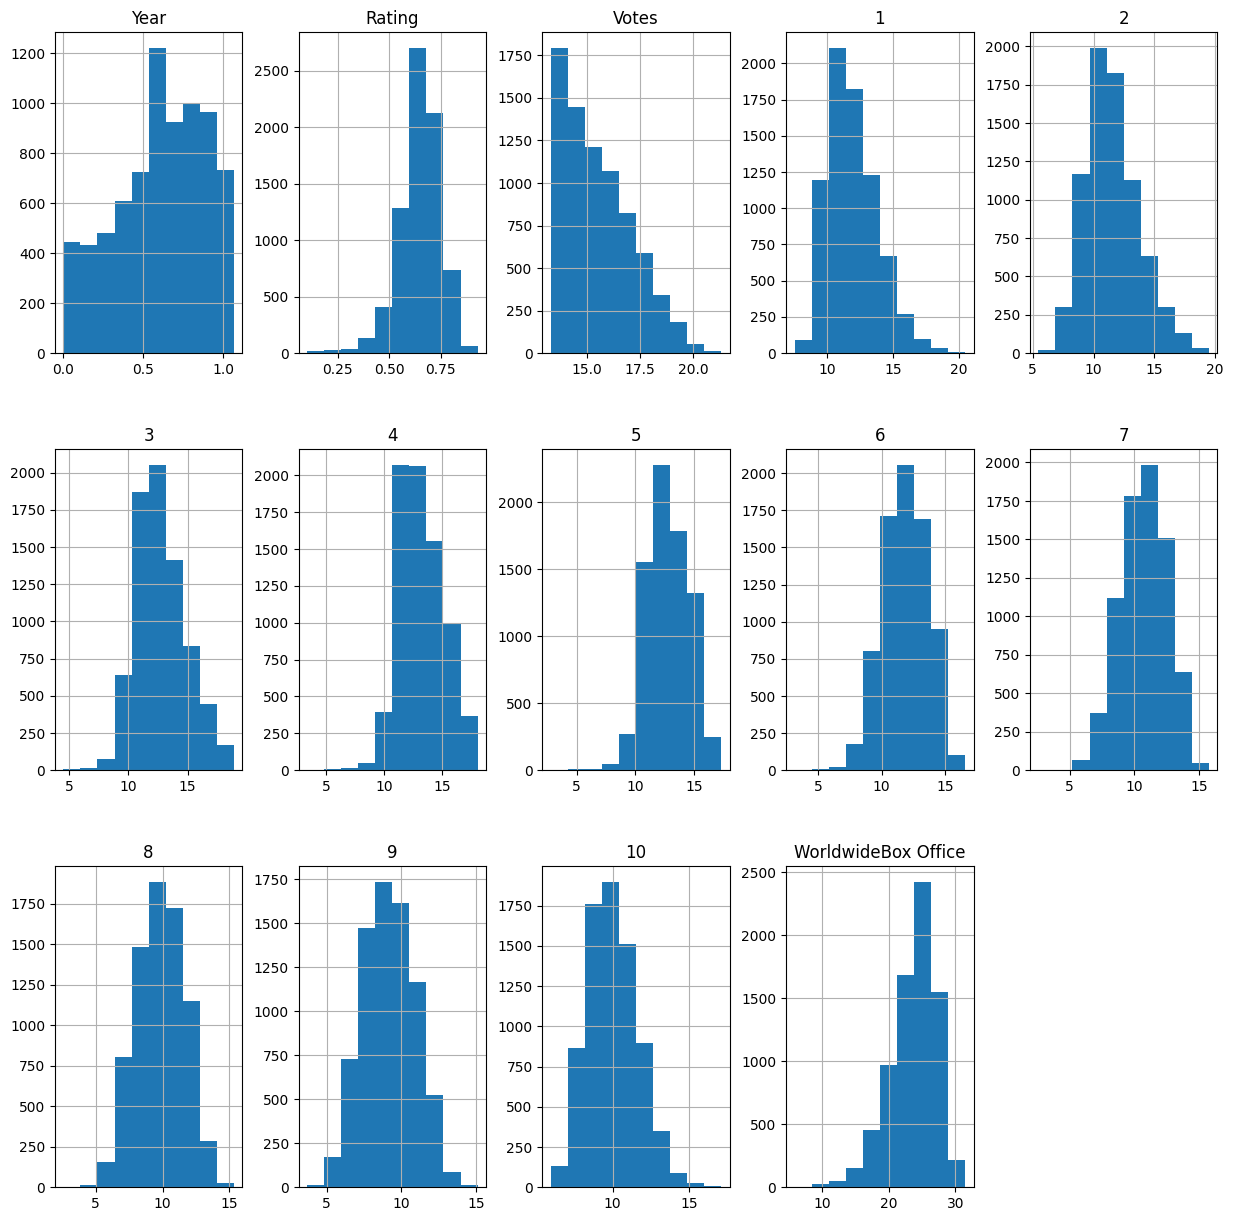

In [4]:
print("AFTER NORMALIZATIONS")
data[data.columns[1:]].hist(layout=(3,5), figsize=(15,15));

In [5]:
import math 
SEED = int(math.sqrt(201401004 + 191401009))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Title','WorldwideBox Office'], axis=1), data['WorldwideBox Office'], test_size=0.10, random_state=SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1111111111111111, random_state=SEED)

In [7]:
print("train percentage:", round(len(X_train)/len(data)*100),"%", sep="")
print("test percentage:", round(len(X_test)/len(data)*100),"%", sep="")
print("validation percentage:", round(len(X_validation)/len(data)*100),"%", sep="")
K = 10

train percentage:80%
test percentage:10%
validation percentage:10%


# Models

## Linear regression

In [8]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(X_train, y_train)
print("LinearRegression score on train:", LR.score(X_train, y_train))

LinearRegression score on train: 0.49959889823472303


In [9]:
LR_validation_prediction = LR.predict(X_validation)

from sklearn.metrics import mean_squared_error
print("Logistic Regression mean squared error on validation:", mean_squared_error(y_validation, LR_validation_prediction, squared=True))

from sklearn.metrics import mean_squared_error
print("Logistic Regression root mean squared error on validation:", mean_squared_error(y_validation, LR_validation_prediction ,squared=False))

from sklearn.metrics import mean_absolute_error
print("Logistic Regression mean absolute error on validation:", mean_absolute_error(y_validation, LR_validation_prediction))

from sklearn.metrics import r2_score
print("Logistic Regression r2 score on validation:", r2_score(y_validation, LR_validation_prediction))

#Adjusted R Squared:
print("Logistic Regression adjusted r2 score on validation:", 1-(1-r2_score(y_validation, LR_validation_prediction))*((len(y_validation))-1)/((len(y_validation))-len(X_validation.columns)))

Logistic Regression mean squared error on validation: 6.5912824860538874
Logistic Regression root mean squared error on validation: 2.567349311265198
Logistic Regression mean absolute error on validation: 1.783157472910163
Logistic Regression r2 score on validation: 0.4834905737315801
Logistic Regression adjusted r2 score on validation: 0.47511474519749763


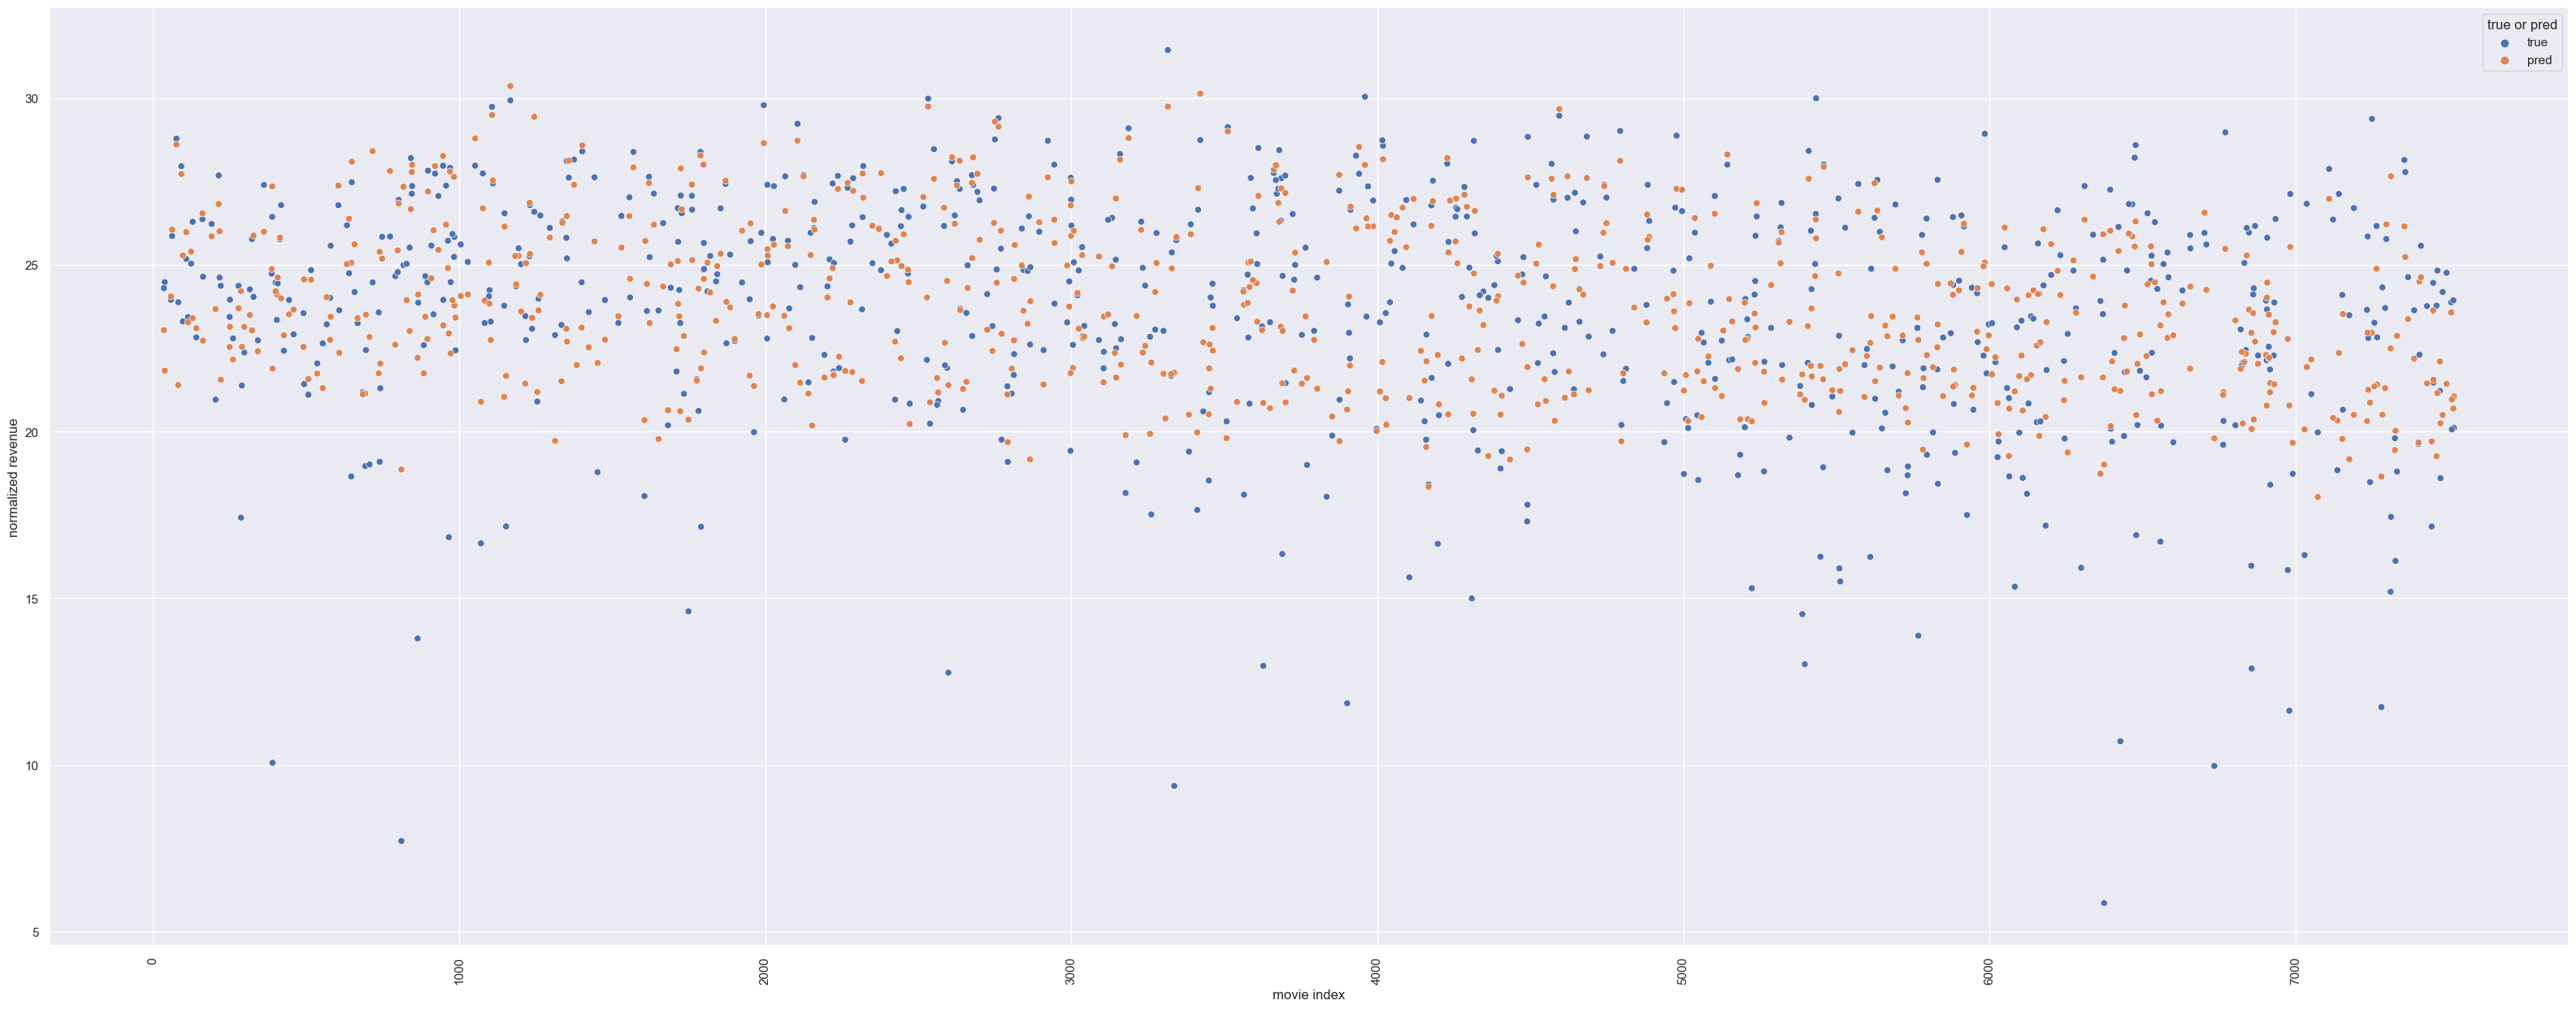

In [16]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(40,15)})
sns.scatterplot(data=pd.DataFrame({"movie index": list(y_validation.index)*2, 'normalized revenue': np.hstack((y_validation, LR_validation_prediction)), 'true or pred': np.hstack((["true"]*len(y_validation) , ["pred"]*len(LR_validation_prediction)))}),
                x="movie index",
                y="normalized revenue",
                hue="true or pred")
plt.xticks(rotation=90);

In [30]:
LR_df = pd.DataFrame({"pred": np.round(2**LR_validation_prediction), "actual": np.round(2**y_validation)})

In [32]:
LR_df[abs(LR_df['pred']-LR_df['actual']) >= 20000000]

,pred,actual
6176,70450248.0,21947454.0
2999,61441224.0,130154568.0
4118,132275366.0,77912251.0
108,66342369.0,38039850.0
1265,18042951.0,93900680.0
...,...,...
4082,110686665.0,31556061.0
2945,52997109.0,15001776.0
4995,160115391.0,102731865.0
4672,18109922.0,123066041.0


## Polynomial regression

## Support vector regression

## random forest regression

## logistic regression

## Neural network